<a href="https://colab.research.google.com/github/MOEINSOHA/MOEINSOHA/blob/main/SwinTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d johncapocyan/cellnet-beta-version

Dataset URL: https://www.kaggle.com/datasets/johncapocyan/cellnet-beta-version
License(s): MIT
100% 9.68G/9.68G [10:35<00:00, 16.5MB/s]
100% 9.68G/9.68G [10:35<00:00, 16.4MB/s]


In [ ]:
!pip install timm


In [ ]:
!unzip /content/cellnet-beta-version.zip

In [4]:
import shutil
# transfer folders
source_folder = '/content/CellNet/CellNet/Colon_Benign'
destination_folder = '/content/Colon'
shutil.move(source_folder, destination_folder)
print('moved')


moved


In [3]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import timm
from tqdm import tqdm

# 1. Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Swin Transformer typically uses 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained models expect this normalization
])

# 3. Load dataset
data_path = '/content/Colon'  # Update this path with your dataset path
dataset = ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 3.5 Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 4. Load a pre-trained Swin Transformer model (Swin-Tiny, for example)
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2).to(device)  # num_classes=2 for benign and adenocarcinoma

# 5. Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 6. Training loop
def train(model, dataloader, criterion, optimizer, num_epochs=2):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")

# 7. Start training
train(model, dataloader, criterion, optimizer, num_epochs=2)

# 8. Save the trained model
torch.save(model.state_dict(), '/content/swin_transformer_colon.pth')


100%|██████████| 313/313 [03:22<00:00,  1.55it/s]


Epoch [1/2], Loss: 0.0200


100%|██████████| 313/313 [03:22<00:00,  1.55it/s]


Epoch [2/2], Loss: 0.0012


In [4]:
def evaluate_accuracy(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on validation set: {accuracy:.2f}%')

# Evaluate the model
evaluate_accuracy(model, val_loader)


Accuracy on validation set: 100.00%


In [5]:
from sklearn.metrics import precision_score, recall_score

def evaluate_precision_recall(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

# Evaluate precision and recall
evaluate_precision_recall(model, val_loader)


Precision: 1.0000
Recall: 1.0000


In [6]:
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

# Evaluate confusion matrix
evaluate_confusion_matrix(model, val_loader)


Confusion Matrix:
[[1023    0]
 [   0  977]]


Total correct predictions: 32


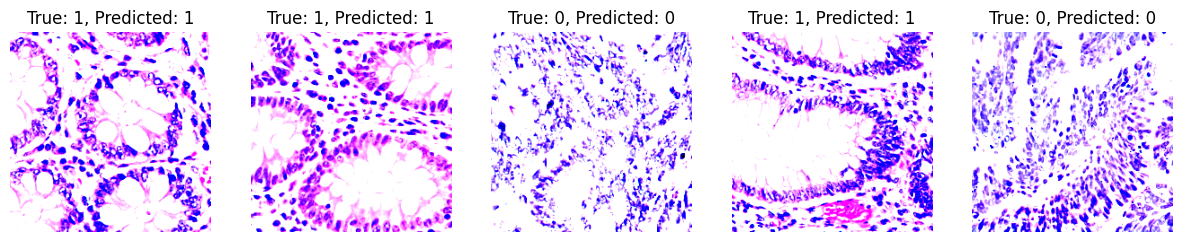

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_with_images(model, dataloader, num_images=5):
    model.eval()  # Set the model to evaluation mode

    total_correct = 0
    all_images = []
    all_labels = []
    true_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
            total_correct += (predicted == labels).sum().item()  # Count correct predictions

            # Collect images and labels
            all_images.extend(images.cpu().numpy())
            all_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())  # Collect true labels

            # Stop if we've collected enough images
            if len(all_images) >= num_images:
                break

    # Calculate the total correct predictions
    print(f"Total correct predictions: {total_correct}")

    # Display images with true and predicted labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax, img, pred, true in zip(axes, all_images[:num_images], all_labels[:num_images], true_labels[:num_images]):
        ax.imshow(np.transpose(img, (1, 2, 0)))  # Change the color channel order
        ax.set_title(f"True: {true}, Predicted: {pred}")
        ax.axis('off')

    plt.show()

# Example usage:
evaluate_model_with_images(model, val_loader, num_images=5)  # Change num_images to desired number of images
